In [1]:
# univariate multi-step lstm
from math import sqrt
import numpy as np
from numpy import split
from numpy import array
from pandas import read_csv
import pandas as pd
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

C:\Users\Abraham\AppData\Local\Temp/ipykernel_20816/3615794610.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


#Carga de dataset
Los datos de ipc se cargan de un archivo cvs 

In [2]:

#importar datos guardados de archivos .csv 
def parser(x):
	return datetime.strptime(x, "%d/%m/%Y")
datasett = read_csv("IPC_VAR_MENSUAL.csv",sep=";",date_parser=parser, index_col=0, squeeze=False,decimal=",",
                      names=["Fechas","IPC General","IPC SAE","IPC sin volatiles"],parse_dates=True,skiprows=3,encoding="latin-1")


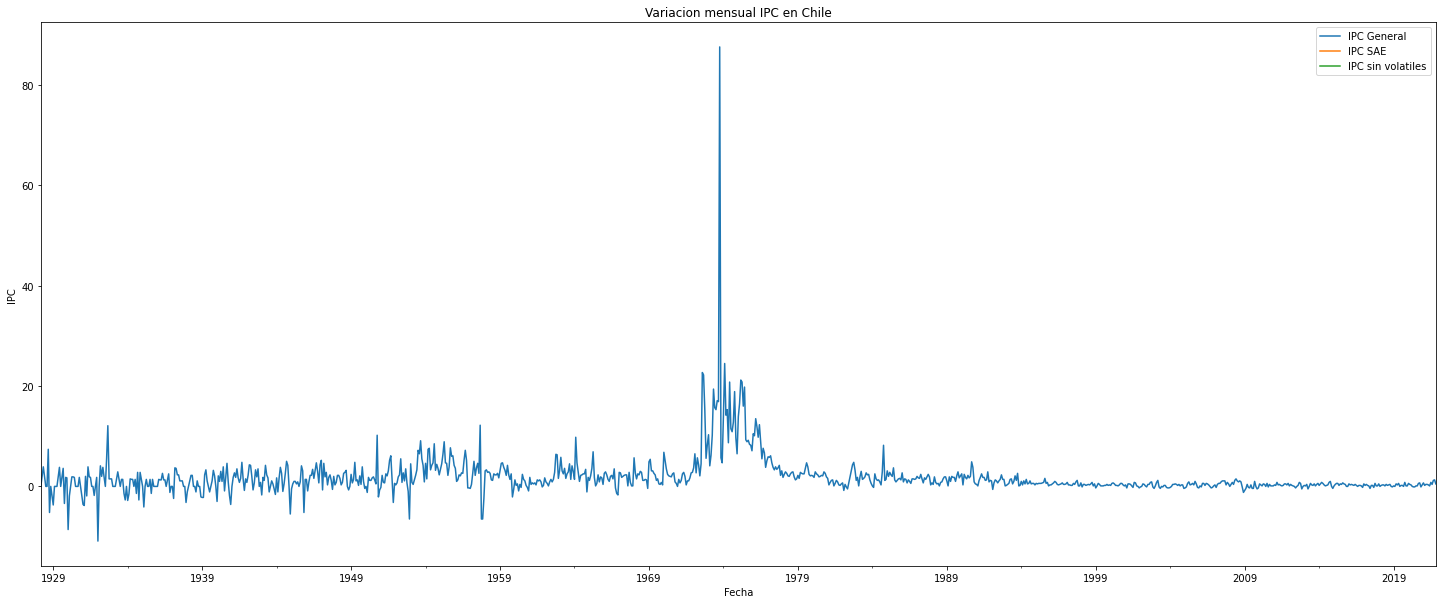

In [3]:

datasett.plot(figsize=(25,10), title = "Variacion mensual IPC en Chile")
plt.ylabel("IPC")
plt.xlabel("Fecha")
dataset = datasett["IPC General"]

In [4]:
dataset.describe()

count    1125.000000
mean        1.824622
std         4.088995
min       -10.900000
25%         0.200000
50%         1.000000
75%         2.300000
max        87.600000
Name: IPC General, dtype: float64

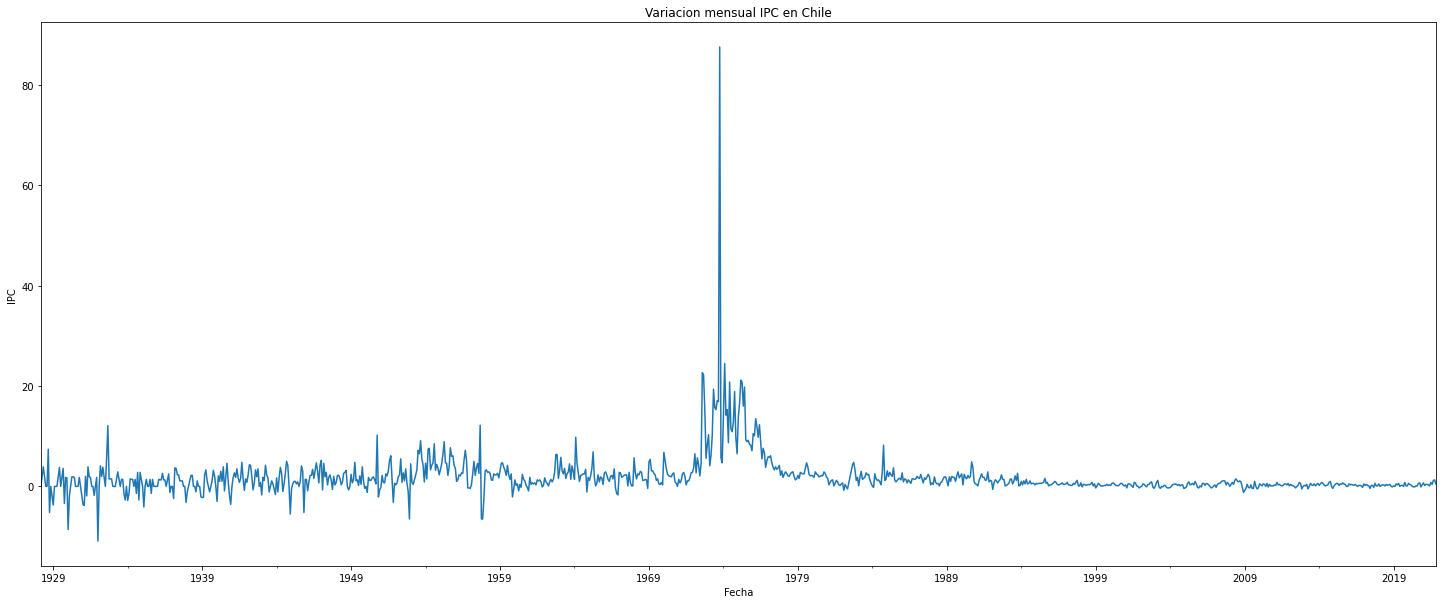

In [5]:
dataset.plot(figsize=(25,10), title = "Variacion mensual IPC en Chile")
plt.ylabel("IPC")
plt.xlabel("Fecha")
plt.show()

#Funciones

In [6]:
def data_supervisado(data, n_input):
    x , y = [] , [] 
    for i in range(n_input,len(data)-n_input):
        x.append(data[i:i+n_input])
        y.append(data[i+n_input])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [8]:
def prepare_data(data,n_input,n_test):
  data = data.values
  data = data.reshape(len(data), 1)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled_data = scaler.fit_transform(data)
  data_train , data_test  = scaled_data[:-n_test] , scaled_data[-n_test-1:] 
  x_train,y_train = data_supervisado(data_train,n_input)
  x_test,y_test = data_supervisado(data_test,n_input)
  return scaler,x_train,y_train,x_test,y_test

In [9]:
def create_time_steps(length):
    return list(range(-length, 0))
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,
                   label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
        plt.legend()
        plt.xlim([time_steps[0], (future+5)*2])
        plt.xlabel('Time-Step')
    
    return plt

In [10]:
def create_time_steps(length):
    return list(range(-length, 0))

In [11]:
def fit_model(X,y,n_neurons,n_epoch,n_batch,n_input,n_feacture,x_val,y_val):
  verbo =   0
  model = Sequential()
  model.add(LSTM(10 , input_shape=(n_input,1),activation='tanh',))
  model.add(Dense(1))
  model.compile(optimizer= "adam", loss = "mse",metrics=["mse"])
  losses = []
  val_losses = []
  min_val_loss = (99999,999999)
  #history = model.fit(X, y, validation_data=(x_val,y_val), epochs=n_epoch, batch_size=n_batch, verbose=verbose ,shuffle=False)
  train_rmse, test_rmse = list(), list()
  for i in range(n_epoch):
      history = model.fit(X, y,epochs= 1,validation_data=(x_val,y_val), batch_size=n_batch, verbose=0 ,shuffle=False)
      losses.append(history.history['loss'])
      val_losses.append(history.history['val_loss'][0])
      model.reset_states()
  """print('best val_loss and epoch:',min_val_loss)
  plt.title('loss')
  plt.plot(losses,label="Train")
  plt.plot(val_losses, color='red',label="validation")
  plt.show()"""
  return model , losses ,val_losses

In [12]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[1]-1):
        x_test[0][i][0] = x_test[0][i+1][0]
    x_test[0][x_test.shape[1]-1][0]=nuevoValor
    return x_test
 

In [13]:
def plot_predic_data(dataset , n_input , n_test):
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    x_trains = x_train.reshape(x_train.shape[0],x_train.shape[1])
    inv_xtrain = scaler.inverse_transform(x_trains)
    inv_ytrain = scaler.inverse_transform(y_train)
    x_tests = x_test.reshape(x_test.shape[0],x_test.shape[1])
    inv_xtest = scaler.inverse_transform(x_tests)
    inv_ytest = scaler.inverse_transform(y_test)
    results=model.predict(x_train,1)
    results = scaler.inverse_transform(results)
    results = results.reshape(results.shape[0])
    plt.plot(range(len(inv_ytrain)),inv_ytrain,c='g',label = 'true values')
    plt.plot(range(len(results)),results,c='r', label = 'predicts')
    plt.title('train')
    plt.legend()
    plt.show()
    results=model.predict(x_test,1)
    results = scaler.inverse_transform(results)
    results = results.reshape(len(results))
    plt.plot(range(len(inv_ytest)),inv_ytest,c='g',label = 'true values')
    plt.plot(range(len(results)),results,c='r', label = 'predicts')
    plt.legend()
    plt.title('test')
    plt.show()

In [26]:
def create_time_steps(length):
    return list(range(-length, 1))
def plot_multi_step(history,forecast,n_input):
    plt.figure(figsize=(18, 6))
    forecast = forecast.reshape(n_input,1)
    num_in = create_time_steps(len(history)-1)
    num_out = len(history)
    plt.plot(num_in,history, label = 'history')
    plt.plot(np.arange(num_out),forecast,c='g',label = 'predicts')
    plt.legend()
    plt.show()

In [15]:
def multi_step(dataset , n_input , n_test):
    predicts = []
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    x_forecat = dataset[-n_input::]
    x_forecats =x_forecat.values.reshape(x_forecat.shape[0],1)
    x_forecats = scaler.fit_transform(x_forecats)
    x_forecats =x_forecats.reshape(1,x_forecats.shape[0],1)
    for i in range(n_input-1):
        parcial=model.predict(x_forecats)
        predicts.append(parcial[0])
        x_forecats=agregarNuevoValor(x_forecats,parcial[0])
    x_forecats = x_forecats.reshape(x_forecats.shape[0],x_forecats.shape[1])
    x_forecats_true = scaler.inverse_transform(x_forecats)
    return x_forecats_true

#Pruebas

In [16]:
def run(dataset):
    #configure
    n_input = 6
    n_feacture = 1
    n_neurons = 1
    n_epoch = 1000
    n_test = int(len(dataset)*0.2)   #20% de los datos van a hacer de prueba
    #preparation data
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    # reshape input to be 3D [samples, timesteps, features]
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    x_trains = x_train.reshape(x_train.shape[0],x_train.shape[1])
    inv_xtrain = scaler.inverse_transform(x_trains)
    inv_ytrain = scaler.inverse_transform(y_train)
    x_tests = x_test.reshape(x_test.shape[0],x_test.shape[1])
    inv_xtest = scaler.inverse_transform(x_tests)
    inv_ytest = scaler.inverse_transform(y_test)
    #plot forecast test
    #show_plot([inv_xtest[len(inv_xtest)-2],inv_ytest[len(inv_xtest)-2]],0,'datos de prueba')
    plt.show
    history_loss = []
    model,  loss , val_loss = fit_model(x_train,y_train,n_neurons,n_epoch,
                            1,n_input,n_feacture,x_test,y_test)
    losses = []
    val_losses = []
    return model, loss,val_loss


In [17]:
def evaluate(ciclos,dataset,n_epoch):
    datasett = dataset.values
    #configure
    n_input = 12
    n_feacture = 1
    n_neurons = 1
    n_test = int(len(dataset)*0.2)   #20% de los datos van a hacer de prueba
    #preparation data
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    # reshape input to be 3D [samples, timesteps, features]
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    x_trains = x_train.reshape(x_train.shape[0],x_train.shape[1])
    inv_xtrain = scaler.inverse_transform(x_trains)
    inv_ytrain = scaler.inverse_transform(y_train)
    x_tests = x_test.reshape(x_test.shape[0],x_test.shape[1])
    inv_xtest = scaler.inverse_transform(x_tests)
    inv_ytest = scaler.inverse_transform(y_test)
    #plot forecast test
    #show_plot([inv_xtest[len(inv_xtest)-2],inv_ytest[len(inv_xtest)-2]],0,'datos de prueba')
    #plt.show
    history_loss = []
    error_score = list()
    for r in range(ciclos):
        print(n_epoch)
        model,  loss , val_loss = fit_model(x_train,y_train,n_neurons,n_epoch,
                            1,n_input,n_feacture,x_test,y_test)
        pred_test = model.predict(x_test)
        prediction = list()
        pred_test =  scaler.inverse_transform(pred_test)
        inv_ytest = inv_ytest.reshape(inv_ytest.shape[0])
        rmse = sqrt(mean_squared_error(inv_ytest,pred_test))
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_score.append(rmse)
    losses = []
    val_losses = []
    return error_score

In [18]:
#No hace falta correr esta celda ya que es solo para evaluar los diferentes hiperparametros
from pandas import DataFrame
# experiment
repeats = 5
results = DataFrame()
# vary training epochs
epochs = [ 5000]
for e in epochs:
	results[str(e)] = evaluate(repeats, dataset,e)
# summarize results
print(results.describe())
# save boxplot
results.boxplot()
plt.savefig('boxplot_epoch_var.png')
results.plot()
plt.savefig("results_ASDFAD.png")

(876, 12, 1) (876, 1) (202, 12, 1) (202, 1)
5000
1) Test RMSE: 0.403
5000
2) Test RMSE: 0.377
5000
3) Test RMSE: 0.406
5000
4) Test RMSE: 0.386
5000
5) Test RMSE: 0.408


In [82]:
data = dataset
model , loss, val_loss = run(data)
model.save('modelo_recursivo.h5')
plt.plot(loss)
plt.plot(val_loss)
plt.show()

(876, 12, 1) (876, 1) (202, 12, 1) (202, 1)


In [18]:
import keras
model = keras.models.load_model('modelo_recursivo.h5')

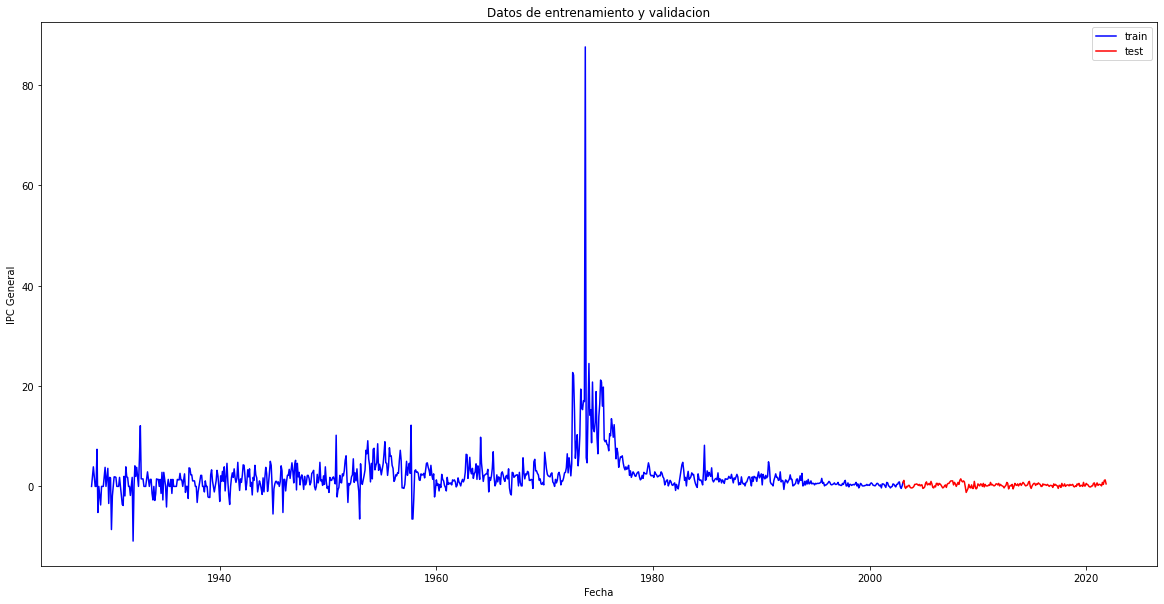

In [21]:
n_test = int(len(dataset)*0.2)
plt.figure(figsize=(20,10))
plt.title('Datos de entrenamiento y validacion')
plt.ylabel('IPC General')
plt.xlabel('Fecha')
plt.plot( dataset[:-n_test], color = 'b',label = 'train')
plt.plot(dataset[-n_test-1:],color = 'r',label = 'test')
plt.legend()
plt.show()

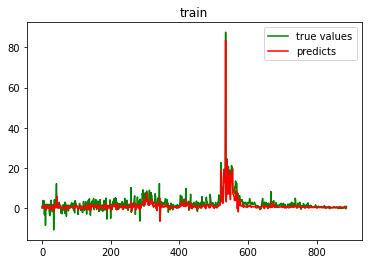

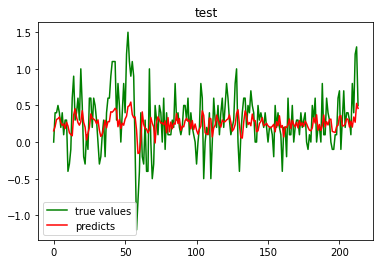

In [22]:
n_input = 6
plot_predic_data(dataset , n_input , n_test)

In [23]:
#Mustra los 6 valores futuro despues de los ultimos datos
forecast = multi_step(dataset , n_input , n_test)
forecast


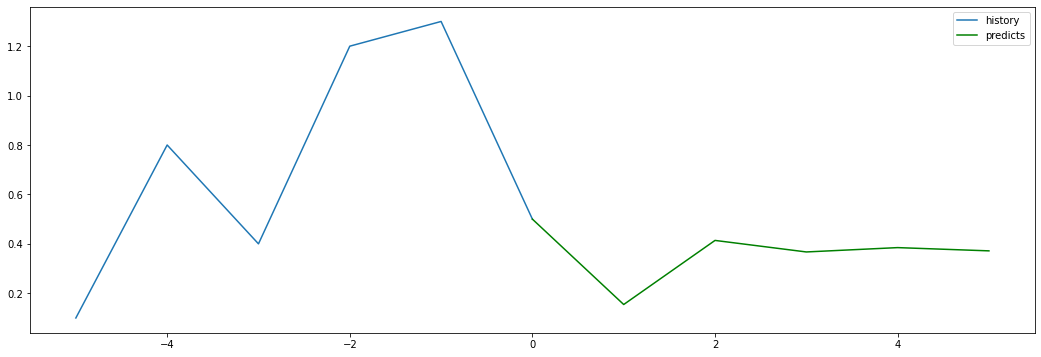

In [27]:
history_data = dataset[-n_input::]
plot_multi_step(history_data , forecast,n_input)

In [119]:
def create_time_steps(length):
    return list(range(-length, 0))
def forecast_plot(history,true_value ,prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction)
    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out), true_value, 'green',
             label='true value')
    plt.plot(np.arange(num_out), prediction, 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [67]:
predicts = []
scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
x_forecat = dataset[-12:-6:]
x_forecats =x_forecat.values.reshape(x_forecat.shape[0],1)
x_forecats = scaler.fit_transform(x_forecats)
x_forecats =x_forecats.reshape(1,x_forecats.shape[0],1)
for i in range(n_input-1):
    parcial=model.predict(x_forecats)
    predicts.append(parcial[0])
    x_forecats=agregarNuevoValor(x_forecats,parcial[0])
x_forecats = x_forecats.reshape(x_forecats.shape[0],x_forecats.shape[1])
x_forecats_true = scaler.inverse_transform(x_forecats)

In [109]:
xtrue = dataset[-12:-6:]
xtrue = xtrue.values.reshape(1,6)
ytrue = dataset[-6::]
ytrue = ytrue.values.reshape(1,6)

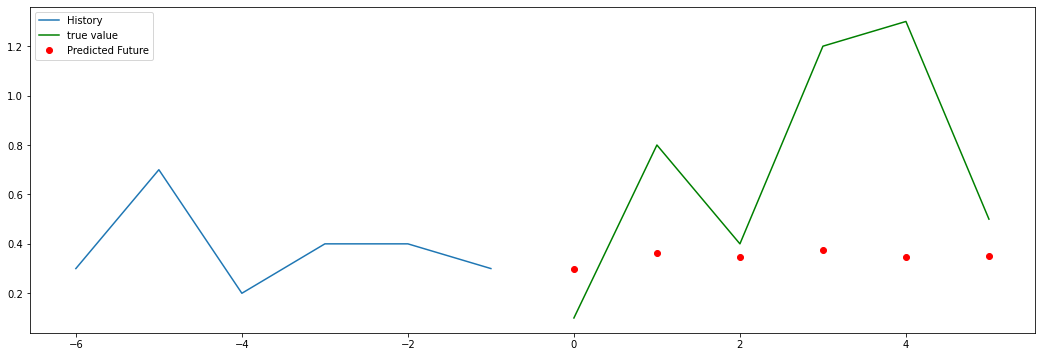

In [120]:
forecast_plot(xtrue[0],ytrue[0],x_forecats_true[0])

In [98]:
#Predicciones del mes de junio a diciembre
print(x_forecats_true)

[[0.3        0.36169222 0.34489856 0.37323312 0.34859301 0.34937598]]


In [26]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 10)                480       
                                                                 
 dense_5 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
